# 搭建多特征群，并进行细致的数据观察

## 数据和包的引入

In [3]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import json 
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from itertools import product
import ast

In [4]:
path = 'E:/Machine-learning/kdd_cup_2019/data_set_phase1/'
data=pd.read_csv(path + '/feature_data/feature.csv', parse_dates=['req_time'])

In [3]:
print(data.head())
print(data.columns.values)

   click_mode           click_time             d             o       pid  \
0         9.0  2018-11-02 17:54:32  116.32,39.96  116.29,39.97       NaN   
1         1.0  2018-11-16 10:53:32  116.33,39.79  116.39,39.84  210736.0   
2         9.0  2018-10-06 10:34:23  116.27,40.00  116.31,39.93       NaN   
3         1.0  2018-11-23 14:54:18  116.39,39.90  116.27,39.88  202427.0   
4         7.0  2018-10-30 11:49:04  116.37,39.86  116.34,39.96  172251.0   

             plan_time                                              plans  \
0  2018-11-02 17:54:30  [{"distance": 5219, "price": 300, "eta": 1367,...   
1  2018-11-16 10:53:10  [{"distance": 13864, "price": 600, "eta": 3221...   
2  2018-10-06 10:33:58  [{"distance": 12294, "price": 400, "eta": 2472...   
3  2018-11-23 14:54:11  [{"distance": 14853, "price": 1700, "eta": 291...   
4  2018-10-30 11:48:41  [{"distance": 12882, "price": 600, "eta": 3211...   

             req_time      sid   p0  ...  svd_mode_0  svd_mode_1  svd_mode_2  \


## ob特征、距离特征

     已经有：
          起点到终点的欧式距离
          起点、终点到最近地铁站的欧式距离
          起点到终点的欧式距离、经纬度直线距离 

##### 起点到终点的角度

In [58]:
#角度信息无效，降分
from math import radians, atan, tan, sin, acos, cos,atan2
#计算角度函数
def getDegree(lonA,latA,lonB,latB ):
    """
    Args:
        point p1(latA, lonA)
        point p2(latB, lonB)
    Returns:
        bearing between the two GPS points,
        default: the basis of heading direction is north
    """
    radLatA = radians(latA)
    radLonA = radians(lonA)
    radLatB = radians(latB)
    radLonB = radians(lonB)
    dLon = radLonB - radLonA
    y = sin(dLon) * cos(radLatB)
    x = cos(radLatA) * sin(radLatB) - sin(radLatA) * cos(radLatB) * cos(dLon)
    brng = degrees(atan2(y, x))
    brng = (brng + 360) % 360
    return brng
    
data['od_Degree']=data.apply(lambda row:getDegree(row['o_lng'],row['o_lat'],row['d_lng'],row['d_lat']),axis=1)

#### 起点、终点到最近地铁站的最小实际地理距离 （havesine距离）

In [5]:
import math
import swifter 

#引入地铁站数据
subwayinfo    = pd.read_csv('../data/beijing_subway.csv')

#构建真实距离 的最小值
def GetDistance_min(lng1, lat1):
    #print(1)
    lng2=subwayinfo['station_longitude']
    lat2=subwayinfo['station_latitude']
    
    EARTH_RADIUS = 6378.137

    lng1 = lng1 * math.pi / 180.0
    lng2 = lng2 * math.pi / 180.0
    lat1 = lat1 * math.pi / 180.0
    lat2 = lat2 * math.pi / 180.0
    
    s_list=[]

    for i in range(len(lng2)):
        dis1 = lat1 - lat2[i]
        dis2 = lng1 - lng2[i]
        s = 2 * math.asin(
            ((math.sin(dis1 / 2)) ** 2 + math.cos(lat1) * math.cos(lat2[i]) * (math.sin(dis2 / 2)) ** 2) ** 0.5)
        s = s * EARTH_RADIUS * 1000
        s_list.append(s)

    return min(s_list)
data['o_nearest_subway_datail']=data.swifter.apply(lambda row:GetDistance_min(row['o_lng'],row['o_lat']),axis=1)

print('其中一个维度提取完成')
data['d_nearest_subway_datail']=data.swifter.apply(lambda row:GetDistance_min(row['d_lng'],row['d_lat']),axis=1)


其中一个维度提取完成


In [7]:
data[['o_nearest_subway_datail','d_nearest_subway_datail']].to_csv(path + '/feature_data/subway_distance_datail.csv')

In [8]:
from multiprocessing import cpu_count
print(cpu_count())

8


#### 到达公交站的最近欧式距离、最小实际地理距离

In [5]:
#引入公交站点经纬度
path = 'E:/Machine-learning/kdd_cup_2019/data/'
bus_data=pd.read_csv(path + 'beijing_bus_station.csv')

#构建与最近的公交站站之间的欧式距离
data['o_nearest_bus_dis'] = np.nan
data['d_nearest_bus_dis'] = np.nan

def get_o_near(x):
    return ((abs(bus_data['lng']-x['o_lng'])+abs(bus_data['lat']-x['o_lat'])).min())
def get_d_near(x):
    return ((abs(bus_data['lng']-x['d_lng'])+abs(bus_data['lat']-x['d_lat'])).min())

data['o_nearest_bus_dis']=data.apply(get_o_near,axis=1)
data['d_nearest_bus_dis']=data.apply(get_d_near,axis=1) 


# #构建真实距离 的最小值
# def GetDistance_min(lng1, lat1):
#     lng2=bus_data['lng']
#     lat2=bus_data['lat']
    
#     EARTH_RADIUS = 6378.137

#     lng1 = lng1 * math.pi / 180.0
#     lng2 = lng2 * math.pi / 180.0
#     lat1 = lat1 * math.pi / 180.0
#     lat2 = lat2 * math.pi / 180.0

#     dis1 = lat1 - lat2
#     dis2 = lng1 - lng2

#     s_list=[]

#     for i in range(len(lng2)):
#         #print(2)
#         dis1 = lat1 - lat2[i]
#         dis2 = lng1 - lng2[i]
#         #print(dis1)
#         s = 2 * math.asin(
#             ((math.sin(dis1 / 2)) ** 2 + math.cos(lat1) * math.cos(lat2[i]) * (math.sin(dis2 / 2)) ** 2) ** 0.5)
#         #print(4)
#         s = s * EARTH_RADIUS * 1000
#         s_list.append(s)

#     return min(s_list)
# data['o_nearest_bus_dis_datail']=data.apply(lambda row:GetDistance_min(row['o_lng'],row['o_lat']),axis=1)
# data['d_nearest_bus_dis_datail']=data.apply(lambda row:GetDistance_min(row['d_lng'],row['d_lat']),axis=1)


#### 距离的分箱特征

In [ ]:
# data['real_dis_60000'] = data['real_dis'].apply(lambda x:1 if x>=60000 else 0)
# data['real_dis_10000'] = data['real_dis'].apply(lambda x:1 if x<=10000 else 0)
# data['real_dis_7500'] = data['real_dis'].apply(lambda x:1 if x<=7500 else 0)
# data['real_dis_2500'] = data['real_dis'].apply(lambda x:1 if x<=2500 else 0)

## 原始推荐特征
   

    主要对原始数据中衍生出的特征

#### plan推荐mode平铺特征

     
     其实这里有多种构建思路的，可以平铺成dataframe之后再提取构建， 我这里使用了最简单的代码构建方式，感觉冗余好大，就这样用吧

In [6]:
#对plans内的信息直接进行平铺，平铺时求取  每个mode的距离、price、eta，根据mode在plan中出现的次序给出排名信息。   这样就构建了11*n个特征

data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
def gen_plan_pingpu_feas(data):  
    #创建用于放置   mode平均距离、平均价格、平均eta、出现位置排名  共11个模式的   11*4个特征     （为0的模式就不做标识了）    添加model所属的工具模态
    n                                           = data.shape[0]
    #mode_list_feas                              = np.zeros((n, 12))
    model_1_dist,model_1_price,model_1_eta,model_1_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_2_dist,model_2_price,model_2_eta,model_2_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_3_dist,model_3_price,model_3_eta,model_3_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_4_dist,model_4_price,model_4_eta,model_4_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_5_dist,model_5_price,model_5_eta,model_5_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_6_dist,model_6_price,model_6_eta,model_6_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_7_dist,model_7_price,model_7_eta,model_7_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_8_dist,model_8_price,model_8_eta,model_8_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_9_dist,model_9_price,model_9_eta,model_9_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_10_dist,model_10_price,model_10_eta,model_10_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_11_dist,model_11_price,model_11_eta,model_11_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    n=0
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list   = []
        else:
            cur_plan_list   = plan
        if len(cur_plan_list) == 0:
            model_1_dist[i]=-1
            model_1_price[i]=-1
            model_1_eta[i]=-1
            model_1_rank[i]=-1
            model_2_dist[i]=-1
            model_2_price[i]=-1
            model_2_eta[i]=-1
            model_2_rank[i]=-1
            model_3_dist[i]=-1
            model_3_price[i]=-1
            model_3_eta[i]=-1
            model_3_rank[i]=-1
            model_4_dist[i]=-1
            model_4_price[i]=-1
            model_4_eta[i]=-1
            model_4_rank[i]=-1
            model_5_dist[i]=-1
            model_5_price[i]=-1
            model_5_eta[i]=-1
            model_5_rank[i]=-1
            model_6_dist[i]=-1
            model_6_price[i]=-1
            model_6_eta[i]=-1
            model_6_rank[i]=-1
            model_7_dist[i]=-1
            model_7_price[i]=-1
            model_7_eta[i]=-1
            model_7_rank[i]=-1
            model_8_dist[i]=-1
            model_8_price[i]=-1
            model_8_eta[i]=-1
            model_8_rank[i]=-1
            model_9_dist[i]=-1
            model_9_price[i]=-1
            model_9_eta[i]=-1
            model_9_rank[i]=-1
            model_10_dist[i]=-1
            model_10_price[i]=-1
            model_10_eta[i]=-1
            model_10_rank[i]=-1
            model_11_dist[i]=-1
            model_11_price[i]=-1
            model_11_eta[i]=-1
            model_11_rank[i]=-1
        else:
            
            model_1_dist_list=[]
            model_1_price_list=[]
            model_1_eta_list=[]
            model_1_rank_list=[]
            model_2_dist_list=[]
            model_2_price_list=[]
            model_2_eta_list=[]
            model_2_rank_list=[]
            model_3_dist_list=[]
            model_3_price_list=[]
            model_3_eta_list=[]
            model_3_rank_list=[]
            model_4_dist_list=[]
            model_4_price_list=[]
            model_4_eta_list=[]
            model_4_rank_list=[]
            model_5_dist_list=[]
            model_5_price_list=[]
            model_5_eta_list=[]
            model_5_rank_list=[]
            model_6_dist_list=[]
            model_6_price_list=[]
            model_6_eta_list=[]
            model_6_rank_list=[]
            model_7_dist_list=[]
            model_7_price_list=[]
            model_7_eta_list=[]
            model_7_rank_list=[]
            model_8_dist_list=[]
            model_8_price_list=[]
            model_8_eta_list=[]
            model_8_rank_list=[]
            model_9_dist_list=[]
            model_9_price_list=[]
            model_9_eta_list=[]
            model_9_rank_list=[]
            model_10_dist_list=[]
            model_10_price_list=[]
            model_10_eta_list=[]
            model_10_rank_list=[]
            model_11_dist_list=[]
            model_11_price_list=[]
            model_11_eta_list=[]
            model_11_rank_list=[]

            mode_list = []
            for tmp_dit in cur_plan_list:
                if tmp_dit['price'] == '':
                    tmp_dit['price']=0
                if tmp_dit['transport_mode']==1:
                    model_1_dist_list.append(int(tmp_dit['distance']))
                    model_1_price_list.append(int(tmp_dit['price']))
                    model_1_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==2:
                    model_2_dist_list.append(int(tmp_dit['distance']))
                    model_2_price_list.append(int(tmp_dit['price']))
                    model_2_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==3:
                    model_3_dist_list.append(int(tmp_dit['distance']))
                    model_3_price_list.append(int(tmp_dit['price']))
                    model_3_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==4:
                    model_4_dist_list.append(int(tmp_dit['distance']))
                    model_4_price_list.append(int(tmp_dit['price']))
                    model_4_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==5:
                    model_5_dist_list.append(int(tmp_dit['distance']))
                    model_5_price_list.append(int(tmp_dit['price']))
                    model_5_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==6:
                    model_6_dist_list.append(int(tmp_dit['distance']))
                    model_6_price_list.append(int(tmp_dit['price']))
                    model_6_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==7:
                    model_7_dist_list.append(int(tmp_dit['distance']))
                    model_7_price_list.append(int(tmp_dit['price']))
                    model_7_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==8:
                    model_8_dist_list.append(int(tmp_dit['distance']))
                    model_8_price_list.append(int(tmp_dit['price']))
                    model_8_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==9:
                    model_9_dist_list.append(int(tmp_dit['distance']))
                    model_9_price_list.append(int(tmp_dit['price']))
                    model_9_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==10:
                    model_10_dist_list.append(int(tmp_dit['distance']))
                    model_10_price_list.append(int(tmp_dit['price']))
                    model_10_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==11:
                    model_11_dist_list.append(int(tmp_dit['distance']))
                    model_11_price_list.append(int(tmp_dit['price']))
                    model_11_eta_list.append(int(tmp_dit['eta']))
                                             
                mode_list.append(int(tmp_dit['transport_mode']))
            
            
            
            mode_list.extend([1,2,3,4,5,6,7,8,9,10,11])        
            mode_list_end  =len(mode_list)-11
                                             
            model_1_dist[i]=np.mean(model_1_dist_list)
            model_1_price[i]=np.mean(model_1_price_list)
            model_1_eta[i]=np.mean(model_1_eta_list)
            if mode_list.index(1)<mode_list_end:
                model_1_rank[i]=mode_list.index(1)
            else:
                model_1_rank[i]=-1   
                                             
            model_2_dist[i]=np.mean(model_2_dist_list)                  
            model_2_price[i]=np.mean(model_2_price_list)
            model_2_eta[i]=np.mean(model_2_eta_list)
            if mode_list.index(2)<mode_list_end:
                model_2_rank[i]=mode_list.index(2)
            else:
                model_2_rank[i]=-1   
                                                              
            model_3_dist[i]=np.mean(model_3_dist_list)
            model_3_price[i]=np.mean(model_3_price_list)
            model_3_eta[i]=np.mean(model_3_eta_list)
            if mode_list.index(3)<mode_list_end:
                model_3_rank[i]=mode_list.index(3)
            else:
                model_3_rank[i]=-1   
                                                              
            model_4_dist[i]=np.mean(model_4_dist_list)
            model_4_price[i]=np.mean(model_4_price_list)
            model_4_eta[i]=np.mean(model_4_eta_list)
            if mode_list.index(4)<mode_list_end:
                model_4_rank[i]=mode_list.index(4)
            else:
                model_4_rank[i]=-1   
                                                              
            model_5_dist[i]=np.mean(model_5_dist_list)
            model_5_price[i]=np.mean(model_5_price_list)
            model_5_eta[i]=np.mean(model_5_eta_list)
            if mode_list.index(5)<mode_list_end:
                model_5_rank[i]=mode_list.index(5)
            else:
                model_5_rank[i]=-1   
                                                              
            model_6_dist[i]=np.mean(model_6_dist_list)
            model_6_price[i]=np.mean(model_6_price_list)
            model_6_eta[i]=np.mean(model_6_eta_list)
            if mode_list.index(6)<mode_list_end:
                model_6_rank[i]=mode_list.index(6)
            else:
                model_6_rank[i]=-1   
                                                              
            model_7_dist[i]=np.mean(model_7_dist_list)
            model_7_price[i]=np.mean(model_7_price_list)
            model_7_eta[i]=np.mean(model_7_eta_list)
            if mode_list.index(7)<mode_list_end:
                model_7_rank[i]=mode_list.index(7)
            else:
                model_7_rank[i]=-1   
                                                              
            model_8_dist[i]=np.mean(model_8_dist_list)
            model_8_price[i]=np.mean(model_8_price_list)
            model_8_eta[i]=np.mean(model_8_eta_list)
            if mode_list.index(8)<mode_list_end:
                model_8_rank[i]=mode_list.index(8)
            else:
                model_8_rank[i]=-1   
                                                              
            model_9_dist[i]=np.mean(model_9_dist_list)
            model_9_price[i]=np.mean(model_9_price_list)
            model_9_eta[i]=np.mean(model_9_eta_list)
            if mode_list.index(9)<mode_list_end:
                model_9_rank[i]=mode_list.index(8)
            else:
                model_9_rank[i]=-1   
                                                              
            model_10_dist[i]=np.mean(model_10_dist_list)
            model_10_price[i]=np.mean(model_10_price_list)
            model_10_eta[i]=np.mean(model_10_eta_list)
            if mode_list.index(10)<mode_list_end:
                model_10_rank[i]=mode_list.index(10)
            else:
                model_10_rank[i]=-1   
                                                              
            model_11_dist[i]=np.mean(model_11_dist_list)
            model_11_price[i]=np.mean(model_11_price_list)
            model_11_eta[i]=np.mean(model_11_eta_list)
            if mode_list.index(11)<mode_list_end:
                model_11_rank[i]=mode_list.index(11)
            else:
                model_11_rank[i]=-1   
                                             
                                             
                                             
    data['plan_model_1_dist']    =  model_1_dist
    data['plan_model_1_price']    =  model_1_price                      
    data['plan_model_1_eta']    =  model_1_eta     
    data['plan_model_1_rank']    =  model_1_rank 
                                             
    data['plan_model_2_dist']    =  model_2_dist
    data['plan_model_2_price']    =  model_2_price                      
    data['plan_model_2_eta']    =  model_2_eta     
    data['plan_model_2_rank']    =  model_2_rank                                             

    data['plan_model_3_dist']    =  model_3_dist
    data['plan_model_3_price']    =  model_3_price                      
    data['plan_model_3_eta']    =  model_3_eta     
    data['plan_model_3_rank']    =  model_3_rank

    data['plan_model_4_dist']    =  model_4_dist
    data['plan_model_4_price']    =  model_4_price                      
    data['plan_model_4_eta']    =  model_4_eta     
    data['plan_model_4_rank']    =  model_4_rank
                                        
    data['plan_model_5_dist']    =  model_5_dist
    data['plan_model_5_price']    =  model_5_price                      
    data['plan_model_5_eta']    =  model_5_eta     
    data['plan_model_5_rank']    =  model_5_rank
                                             
    data['plan_model_6_dist']    =  model_6_dist
    data['plan_model_6_price']    =  model_6_price                      
    data['plan_model_6_eta']    =  model_6_eta     
    data['plan_model_6_rank']    =  model_6_rank
                                            
    data['plan_model_7_dist']    =  model_7_dist
    data['plan_model_7_price']    =  model_7_price                      
    data['plan_model_7_eta']    =  model_7_eta     
    data['plan_model_7_rank']    =  model_7_rank
                                             
    data['plan_model_8_dist']    =  model_8_dist
    data['plan_model_8_price']    =  model_8_price                      
    data['plan_model_8_eta']    =  model_8_eta     
    data['plan_model_8_rank']    =  model_8_rank
                                             
    data['plan_model_9_dist']    =  model_9_dist
    data['plan_model_9_price']    =  model_9_price                      
    data['plan_model_9_eta']    =  model_9_eta     
    data['plan_model_9_rank']    =  model_9_rank
                                             
    data['plan_model_10_dist']    =  model_10_dist
    data['plan_model_10_price']    =  model_10_price                      
    data['plan_model_10_eta']    =  model_10_eta     
    data['plan_model_10_rank']    =  model_10_rank   

    data['plan_model_11_dist']    =  model_11_dist
    data['plan_model_11_price']    =  model_11_price                      
    data['plan_model_11_eta']    =  model_11_eta     
    data['plan_model_11_rank']    =  model_11_rank
                                             
    return data
                                             
new_df=gen_plan_pingpu_feas(data)
data=new_df

594358it [03:51, 2571.29it/s]


In [8]:
print(new_df.columns.values)

#data=new_df

['click_mode' 'click_time' 'd' 'o' 'pid' 'plan_time' 'plans' 'req_time'
 'sid' 'p0' 'p1' 'p2' 'p3' 'p4' 'p5' 'p6' 'p7' 'p8' 'p9' 'p10' 'p11' 'p12'
 'p13' 'p14' 'p15' 'p16' 'p17' 'p18' 'p19' 'p20' 'p21' 'p22' 'p23' 'p24'
 'p25' 'p26' 'p27' 'p28' 'p29' 'p30' 'p31' 'p32' 'p33' 'p34' 'p35' 'p36'
 'p37' 'p38' 'p39' 'p40' 'p41' 'p42' 'p43' 'p44' 'p45' 'p46' 'p47' 'p48'
 'p49' 'p50' 'p51' 'p52' 'p53' 'p54' 'p55' 'p56' 'p57' 'p58' 'p59' 'p60'
 'p61' 'p62' 'p63' 'p64' 'p65' 'o_lng' 'o_lat' 'd_lng' 'd_lat'
 'od_manhattan_distance' 'od_manhattan_distance_detail'
 'o_main_centroid_mean_dis' 'd_main_centroid_mean_dis'
 'o_main_centroid_mode_dis' 'd_main_centroid_mode_dis' 'o_nearest_dis'
 'd_nearest_dis' 'req_time_hour' 'req_time_weekday' 'req_time_minute'
 'time_diff' 'holiday_flag_0' 'holiday_flag_1' 'holiday_flag_3'
 'svd_fea_0' 'svd_fea_1' 'svd_fea_2' 'svd_fea_3' 'svd_fea_4' 'svd_fea_5'
 'svd_fea_6' 'svd_fea_7' 'svd_fea_8' 'svd_fea_9' 'svd_fea_10' 'svd_fea_11'
 'svd_fea_12' 'svd_fea_13' 'svd_fe

KeyError: 'max_eta'

#### 经纬度label转换
分别尝试对o、d、和od对最label_encoder的转码

In [38]:
#对od对做label_coder      'o','d' 'ODPair' 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

#首先对起点和终点  字符做label转换
le.fit(list(data['o']))
data['o_labe_encoder']=le.transform(list(data['o']))
#data['o_labe_encoder']=le.inverse_transform(list(data['o']))

le.fit(list(data['d']))
data['d_labe_encoder']=le.transform(list(data['d']))

#对od做_拼接，进行label转换

data['od_label_encoder']=data.apply(lambda row:(row['o']+'_'+row['d']),axis=1) 
le.fit(list(data['od_label_encoder']))
data['od_label_encoder']=le.transform(list(data['od_label_encoder']))




In [179]:
#另一种方式 的label_encoder  ，在队友那里是提分的
from sklearn import preprocessing
LB = preprocessing.LabelEncoder()
LB.fit(data['o'].tolist() + data['d'].tolist())
data['o_label_encoder_all'] = LB.transform(data['o'])
data['d_label_encoder_all'] = LB.transform(data['d'])

## 日期特征


    已经做了时间差距、请求时间点的所在小时、分钟、星期几、详细数字时间标识、请求时间的节假日信息（使用独热标识0、1、2标识不同情况）

#### 请求的时间点与 造成6点、中午12点、下午6点、晚上6点的分钟差距

In [135]:
import time
#计算与当天四个时刻点的距离，  分钟差距可以为负数


def diff_6_clock(time_point):
    six_clock=str(time_point.year)+'-'+str(time_point.month)+'-'+str(time_point.day)+' '+str(6)+':0:00'
    six_clock=pd.to_datetime(six_clock)
    the_diff=(six_clock- time_point).total_seconds()
    return abs(the_diff/60)


def diff_12_clock(time_point):
    t12_clock=str(time_point.year)+'-'+str(time_point.month)+'-'+str(time_point.day)+' '+str(12)+':0:00'
    t12_clock=pd.to_datetime(t12_clock)
    the_diff=(t12_clock- time_point).total_seconds()
    return abs(the_diff/60)

def diff_18_clock(time_point):
    t18_clock=str(time_point.year)+'-'+str(time_point.month)+'-'+str(time_point.day)+' '+str(18)+':0:00'
    t18_clock=pd.to_datetime(t18_clock)
    the_diff=(t18_clock- time_point).total_seconds()
    return abs(the_diff/60)

def diff_24_clock(time_point):
    t24_clock=str(time_point.year)+'-'+str(time_point.month)+'-'+str(time_point.day)+' '+str(23)+':59:00'
    t24_clock=pd.to_datetime(t24_clock)
    the_diff=(t24_clock- time_point).total_seconds()
    return abs(the_diff/60)

data['diff_6_cloc']=data['req_time'].apply(diff_6_clock)
print('----  第一差距提取结束  ----')
data['diff_12_clock']=data['req_time'].apply(diff_12_clock)
print('----  第二差距提取结束  ----')
data['diff_18_clock']=data['req_time'].apply(diff_18_clock)
print('----  第三差距提取结束  ----')
data['diff_24_clock']=data['req_time'].apply(diff_24_clock)

print('----  第四差距提取结束  ----')

----  第一差距提取结束  ----
----  第二差距提取结束  ----
----  第三差距提取结束  ----
----  第四差距提取结束  ----


#### 构建时间点所在的小时，分钟等

In [9]:
data['req_time_day']=data.apply(lambda row:row['req_time'].day,axis=1) #直接扔掉
data['req_time_hour']=data.apply(lambda row:row['req_time'].hour,axis=1)
data['req_time_minute']=data.apply(lambda row:row['req_time'].minute,axis=1)
data['req_time_weekday']=data.apply(lambda row:row['req_time'].weekday(),axis=1)


In [53]:
#构建时间上的，微交叉特征
data['hour_minute']=data.apply(lambda row:row['req_time_hour']*60 + row['req_time_minute'],axis=1)
data['week_hour_minute']=data.apply(lambda row:(row['req_time_weekday']*24 + row['req_time_hour'])*60 + row['req_time_minute'],axis=1)
# hour_minute=hour*60 + minute
# week_hour_minute=(week*24 + hour)*60 + minute

0          2
1         16
2          6
3         23
4         30
5         18
6         20
7          3
8         15
9          8
10        23
11         3
12        12
13         3
14        20
15        16
16        29
17         2
18        15
19         5
20        28
21         4
22         4
23        24
24        23
25        20
26         3
27        19
28        16
29        28
          ..
594328     6
594329     3
594330     4
594331     2
594332     3
594333     7
594334     3
594335     3
594336     2
594337     1
594338     1
594339     1
594340     4
594341     1
594342     2
594343     6
594344     3
594345     1
594346     5
594347     1
594348     2
594349     7
594350     3
594351     3
594352     4
594353     1
594354     5
594355     3
594356     4
594357     4
Name: req_time_day, Length: 594358, dtype: int64


#### 时间分箱特征

In [ ]:
data['hour_3_23'] = data['req_time_hour'].apply(lambda x:1 if x>=3 & x <= 23 else 0)
data['hour_5_23'] = data['req_time_hour'].apply(lambda x:1 if x>=5 & x <= 23 else 0)
data['hour_minute'] = data['req_time_hour']*60 + data['req_time_minute']

## 统计特征

#### 统计pid的倾向，使用以往mode点击做统计

In [21]:
#展示每个pid的   进行请求的次数（为了做pid的mode点击倾向特征做准备，防止有些出现次数太小的pid,这样直接做，就会造成很严重的穿越。）
group_pid=data.groupby('pid').size()
print(group_pid)

pid
100000.0      8
100002.0      1
100005.0     41
100006.0      5
100007.0      4
100010.0      3
100011.0    888
100012.0      1
100017.0      2
100018.0      2
100026.0      1
100030.0      1
100031.0     39
100033.0      8
100034.0      8
100036.0      2
100038.0      3
100043.0     10
100044.0      1
100045.0      6
100047.0      2
100048.0      1
100050.0     15
100051.0      5
100052.0     12
100053.0      9
100055.0      3
100057.0      2
100058.0      6
100059.0      1
           ... 
216893.0      3
216894.0     19
216895.0      6
216897.0      3
216898.0      1
216903.0      5
216910.0      1
216912.0      1
216918.0      4
216924.0      1
216926.0      6
216932.0     10
216935.0      1
216940.0      1
216943.0     21
216947.0      5
216951.0      1
216953.0     15
216954.0      1
216959.0      1
216962.0      1
216967.0     58
216968.0      1
216969.0     17
216970.0      6
216972.0      1
216973.0     32
216975.0      1
216976.0      7
216977.0      1
Length: 50166, dtype

这里有个问题是如果对每个pid做  以往mode倾向的统计，会造成很大程度的数据穿越，因为很多pid就出现一次，你做统计构建特征时候就直接 把本列对应的标签作为统计放进去了。。。。。         

     如果使用不包括这行的其他行做统计估计还行,这样应该就不算穿越了，所以穿越往往是指直接的当前行的标签做使用才算穿越吧，  看来是有些新用户pid在 测试集中的，这个要注意下，新用户只能够根据profile和推荐做统计吧。

In [28]:
data['pid'].value_counts()

167770.0    7729
112198.0    6164
116844.0    3863
203487.0    3532
186452.0    3121
202427.0    2730
158443.0    2148
202643.0    2062
191435.0    1738
109311.0    1668
129567.0    1643
147311.0    1567
171246.0    1464
202757.0    1207
199899.0    1193
119374.0    1166
170760.0    1137
160117.0    1102
137947.0    1064
199018.0    1049
107147.0    1018
180178.0     985
191445.0     954
184718.0     931
212590.0     899
100011.0     888
129419.0     867
162056.0     855
169231.0     855
126394.0     841
            ... 
167796.0       1
167797.0       1
210170.0       1
210163.0       1
167807.0       1
210154.0       1
210151.0       1
167815.0       1
167760.0       1
167758.0       1
167751.0       1
210209.0       1
167706.0       1
210283.0       1
210281.0       1
210267.0       1
167710.0       1
210256.0       1
210244.0       1
210243.0       1
210241.0       1
167719.0       1
167720.0       1
167721.0       1
210237.0       1
210236.0       1
167736.0       1
210234.0      

In [27]:
#针对测试集中的数据做统计，  看看测试集中出现的pid是否也是大量有只出现一次的情况，如果这样的话，就会有很多新用户在test里第一次点击了。

for i in list(data.iloc[-300:]['pid']):
    if np.isnan(i)==False:
        print(data[data['pid']==i].shape[0])

119
10
433
59
633
1643
364
393
213
18
1207
768
49
78
146
7
3532
22
11
3
33
22
3
2730
65
5
117
55
8
20
1
7
3532
10
15
11
3121
117
15
217
7729
20
6164
32
1
5
4
20
855
190
49
812
22
2
15
3532
10
213
2
3
78
2
73
3121
899
17
176
1
7729
99
19
88
98
6164
348
6
7729
44
17
196
168
47
47
63
73
27
18
6164
32
16
113
6
360
41
114
659
985
3
3863
40
4
67
1
6
213
1
5
666
7
41
379
155
1
2
63
247
3
25
7
40
8
21
65
287
284
4
29
44
20
116
659
69
6
4
217
4
159
112
105
1643
1
18
22
49
954
60
3532
6
194
30
15
40
248
1193
44
3532
143
15
73
63
354
135
2
21
117
672
7
2
213
112
6
6164
1
1464
26
92
166
4
12
47
3532
1567
71
33
333
12
85
5
27
647
37
4
491
8
76
55
14
3863
15
88
113
117
16
15
260
3
3
20
282
3121
8
8
4
79


这里可以发现在test中存在  有些新的pid进行请求的情况， 不过有些pid真的是请求了很多次，所以可以做做挖掘，可以限定次数，如果除自身外高于一定次数，对其进行mode点击率上的挖掘等,发现最高有将近7000多次的，不了滴。     这样就相当于对每个pid进行建模，可以放在profile中，最后进行拼接。

In [191]:
#尝试svd30
data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
def gen_plan_feas(data):
    n                                           = data.shape[0]
    mode_list_feas                              = np.zeros((n, 12))
    max_dist, min_dist, mean_dist, std_dist     = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_price, min_price, mean_price, std_price = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_eta, min_eta, mean_eta, std_eta         = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    min_dist_mode, max_dist_mode, min_price_mode, max_price_mode, min_eta_mode, max_eta_mode, first_mode = \
    np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
  
    mode_texts = []
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list   = []
        else:
            cur_plan_list   = plan
        if len(cur_plan_list) == 0:
            mode_list_feas[i, 0] =  1
            first_mode[i]        =  0
            max_dist[i]          = -1
            min_dist[i]          = -1
            mean_dist[i]         = -1
            std_dist[i]          = -1
            max_price[i]         = -1
            min_price[i]         = -1
            mean_price[i]        = -1
            std_price[i]         = -1
            max_eta[i]           = -1
            min_eta[i]           = -1
            mean_eta[i]          = -1
            std_eta[i]           = -1
            min_dist_mode[i]     = -1
            max_dist_mode[i]     = -1
            min_price_mode[i]    = -1
            max_price_mode[i]    = -1
            min_eta_mode[i]      = -1
            max_eta_mode[i]      = -1
            mode_texts.append('word_null')
        else:
            distance_list = []
            price_list = []
            eta_list = []
            mode_list = []
            for tmp_dit in cur_plan_list:
                distance_list.append(int(tmp_dit['distance']))
                if tmp_dit['price'] == '':
                    price_list.append(0)
                else:
                    price_list.append(int(tmp_dit['price']))
                eta_list.append(int(tmp_dit['eta']))
                mode_list.append(int(tmp_dit['transport_mode']))
            mode_texts.append(
                ' '.join(['word_{}'.format(mode) for mode in mode_list]))
            distance_list                = np.array(distance_list)
            price_list                   = np.array(price_list)
            eta_list                     = np.array(eta_list)
            mode_list                    = np.array(mode_list, dtype='int')
            mode_list_feas[i, mode_list] = 1
            distance_sort_idx            = np.argsort(distance_list)
            price_sort_idx               = np.argsort(price_list)
            eta_sort_idx                 = np.argsort(eta_list)
            max_dist[i]                  = distance_list[distance_sort_idx[-1]]
            min_dist[i]                  = distance_list[distance_sort_idx[0]]
            mean_dist[i]                 = np.mean(distance_list)
            std_dist[i]                  = np.std(distance_list)
            max_price[i]                 = price_list[price_sort_idx[-1]]
            min_price[i]                 = price_list[price_sort_idx[0]]
            mean_price[i]                = np.mean(price_list)
            std_price[i]                 = np.std(price_list)
            max_eta[i]                   = eta_list[eta_sort_idx[-1]]
            min_eta[i]                   = eta_list[eta_sort_idx[0]]
            mean_eta[i]                  = np.mean(eta_list)
            std_eta[i]                   = np.std(eta_list)
            first_mode[i]                = mode_list[0]
            max_dist_mode[i]             = mode_list[distance_sort_idx[-1]]
            min_dist_mode[i]             = mode_list[distance_sort_idx[0]]
            max_price_mode[i]            = mode_list[price_sort_idx[-1]]
            min_price_mode[i]            = mode_list[price_sort_idx[0]]
            max_eta_mode[i]              = mode_list[eta_sort_idx[-1]]
            min_eta_mode[i]              = mode_list[eta_sort_idx[0]]
    feature_data                   =  pd.DataFrame(mode_list_feas)
    feature_data.columns           =  ['mode_feas_{}'.format(i) for i in range(12)]
    feature_data['max_dist']       =  max_dist
    feature_data['min_dist']       =  min_dist
    feature_data['mean_dist']      =  mean_dist
    feature_data['std_dist']       =  std_dist
    feature_data['max_price']      = max_price
    feature_data['min_price']      = min_price
    feature_data['mean_price']     = mean_price
    feature_data['std_price']      = std_price
    feature_data['max_eta']        = max_eta
    feature_data['min_eta']        = min_eta
    feature_data['mean_eta']       = mean_eta
    feature_data['std_eta']        = std_eta
    feature_data['max_dist_mode']  = max_dist_mode
    feature_data['min_dist_mode']  = min_dist_mode
    feature_data['max_price_mode'] = max_price_mode
    feature_data['min_price_mode'] = min_price_mode
    feature_data['max_eta_mode']   = max_eta_mode
    feature_data['min_eta_mode']   = min_eta_mode
    feature_data['first_mode']     = first_mode
    print('mode tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_vec = tfidf_enc.fit_transform(mode_texts)
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
    mode_svd = svd_enc.fit_transform(tfidf_vec)
    mode_svd = pd.DataFrame(mode_svd)
    mode_svd.columns = ['svd_mode_{}'.format(i) for i in range(10)]
    plan_fea = pd.concat([feature_data, mode_svd], axis=1)
    plan_fea['sid'] = data['sid'].values
    return plan_fea



data_plans = gen_plan_feas(data)
plan_features = [col for col in data_plans.columns if col not in ['sid']]
#data.drop(['mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3', 'svd_mode_4', 'svd_mode_5', 'svd_mode_6', 'svd_mode_7', 'svd_mode_8', 'svd_mode_9'],axis=1,inplace=True)
data = data.merge(data_plans, on='sid', how='left')

83434it [00:13, 6261.00it/s]

KeyboardInterrupt: 

补充下svd的参数说明：
   
   
   
     n_components：输出数据的维度，默认为2

    algorithm：可选‘randomized’和‘arpack’,即SVD的两种求解算法

    n_iter：SVD求解器的迭代次数，当algorithm为‘randomized’有效

    random_state：如果是int，则random_state是随机数生成器使用的种子; 如果是RandomState实例，则random_state是随机数生成器; 如果为None，则随机数生成器是np.random使用的RandomState实例。


In [26]:
print(plan_features)
print(data[plan_features])

['mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3', 'svd_mode_4', 'svd_mode_5', 'svd_mode_6', 'svd_mode_7', 'svd_mode_8', 'svd_mode_9', 'svd_mode_10', 'svd_mode_11', 'svd_mode_12', 'svd_mode_13', 'svd_mode_14']
        mode_feas_0  mode_feas_1  mode_feas_2  mode_feas_3  mode_feas_4  \
0               0.0          0.0          1.0          1.0          1.0   
1               0.0          1.0          0.0          1.0          1.0   
2               0.0          0.0          1.0          1.0          1.0   
3               0.0          1.0       

[594358 rows x 46 columns]


#### 构建点击次数统计特征
统计每个pid一共进行p请求的次数

In [19]:
trian_index = (data.req_time <= '2018-12-01')
trian_data     = data[trian_index].reset_index(drop=True)

pid_list_count=list(trian_data.groupby(by=['pid']).size())
pid_list_count

the_query_count_df=pd.DataFrame()
pid_list=[]
for name,group in trian_data.groupby('pid'):
    #rint(name)
    pid_list.append(name)

the_query_count_df['pid']=pid_list
the_query_count_df['pid_query_count']=pid_list_count

data=data.merge(the_query_count_df, 'left', ['pid']) 


## 计数特征

#### 

## 天气特征

## 排序特征

#### 位置点出现次数排序
首先统计 位置点出现的次数，之后对次数进行大小的排序....

In [134]:
#对地点出现次数进行排序     统计那些 经常是导航起点的位置
#第一步，首先获取每个o 出现的次数

o_appear_count=list(data.groupby(by=['o']).size())
d_appear_count=list(data.groupby(by=['d']).size())

the_query_o_count_df=pd.DataFrame()
the_query_d_count_df=pd.DataFrame()

o_list=[]
for name,group in data.groupby(by=['o']):
    o_list.append(name)
    
d_list=[]
for name,group in data.groupby(by=['d']):
    d_list.append(name)
    
the_query_o_count_df['o']=o_list
the_query_d_count_df['d']=d_list
the_query_o_count_df['o_appear_count']=o_appear_count
the_query_d_count_df['d_appear_count']=d_appear_count



data=data.merge(the_query_o_count_df, 'left', ['o']) 
data=data.merge(the_query_d_count_df, 'left', ['d']) 

print(data.columns.values)
print('-------    构建坐标计数完成    -------')
data['o_appear_count_rank'] = data['o_appear_count'].rank() / float(data.shape[0])
data['d_appear_count_rank'] = data['d_appear_count'].rank() / float(data.shape[0])
data['o_appear_count_rank_buguiyi'] = data['o_appear_count'].rank() 
data['d_appear_count_rank_buguiyi'] = data['d_appear_count'].rank() 
print('-------    排序完成    -------')

#print(data['d_appear_count_rank'])

['click_mode' 'click_time' 'd' 'o' 'pid' 'plan_time' 'plans' 'req_time'
 'sid' 'p0' 'p1' 'p2' 'p3' 'p4' 'p5' 'p6' 'p7' 'p8' 'p9' 'p10' 'p11' 'p12'
 'p13' 'p14' 'p15' 'p16' 'p17' 'p18' 'p19' 'p20' 'p21' 'p22' 'p23' 'p24'
 'p25' 'p26' 'p27' 'p28' 'p29' 'p30' 'p31' 'p32' 'p33' 'p34' 'p35' 'p36'
 'p37' 'p38' 'p39' 'p40' 'p41' 'p42' 'p43' 'p44' 'p45' 'p46' 'p47' 'p48'
 'p49' 'p50' 'p51' 'p52' 'p53' 'p54' 'p55' 'p56' 'p57' 'p58' 'p59' 'p60'
 'p61' 'p62' 'p63' 'p64' 'p65' 'o_lng' 'o_lat' 'd_lng' 'd_lat'
 'od_manhattan_distance' 'od_manhattan_distance_detail'
 'o_main_centroid_mean_dis' 'd_main_centroid_mean_dis'
 'o_main_centroid_mode_dis' 'd_main_centroid_mode_dis' 'o_nearest_dis'
 'd_nearest_dis' 'req_time_hour' 'req_time_weekday' 'req_time_minute'
 'time_diff' 'holiday_flag_0' 'holiday_flag_1' 'holiday_flag_3'
 'svd_fea_0' 'svd_fea_1' 'svd_fea_2' 'svd_fea_3' 'svd_fea_4' 'svd_fea_5'
 'svd_fea_6' 'svd_fea_7' 'svd_fea_8' 'svd_fea_9' 'svd_fea_10' 'svd_fea_11'
 'svd_fea_12' 'svd_fea_13' 'svd_fe

KeyError: 'o_appear_count'

In [124]:
#构建od对出现次数 统计特征，并对该特征进行排序，尝试效果。
data['od_couple']=data.apply(lambda row:(row['o']+'_'+row['d']),axis=1) 

od_appear_count=list(data.groupby(by=['od_couple']).size())

the_query_od_count_df=pd.DataFrame()

od_list=[]
for name,group in data.groupby(by=['od_couple']):
    od_list.append(name)
    
the_query_o_count_df['od_couple']=od_list
the_query_o_count_df['od_couple_count']=od_appear_count

data=data.merge(the_query_o_count_df, 'left', ['od_couple']) 

print(data.columns.values)
print('-------    构建坐标计数完成    -------')
data['od_couple_rank'] = data['od_couple_count'].rank() / float(data.shape[0])
data['od_couple_rank_buguiyi'] = data['od_couple_count'].rank() 
print('-------    排序完成    -------')



['click_mode' 'click_time' 'd' 'o' 'pid' 'plan_time' 'plans' 'req_time'
 'sid' 'p0' 'p1' 'p2' 'p3' 'p4' 'p5' 'p6' 'p7' 'p8' 'p9' 'p10' 'p11' 'p12'
 'p13' 'p14' 'p15' 'p16' 'p17' 'p18' 'p19' 'p20' 'p21' 'p22' 'p23' 'p24'
 'p25' 'p26' 'p27' 'p28' 'p29' 'p30' 'p31' 'p32' 'p33' 'p34' 'p35' 'p36'
 'p37' 'p38' 'p39' 'p40' 'p41' 'p42' 'p43' 'p44' 'p45' 'p46' 'p47' 'p48'
 'p49' 'p50' 'p51' 'p52' 'p53' 'p54' 'p55' 'p56' 'p57' 'p58' 'p59' 'p60'
 'p61' 'p62' 'p63' 'p64' 'p65' 'o_lng' 'o_lat' 'd_lng' 'd_lat'
 'od_manhattan_distance' 'od_manhattan_distance_detail'
 'o_main_centroid_mean_dis' 'd_main_centroid_mean_dis'
 'o_main_centroid_mode_dis' 'd_main_centroid_mode_dis' 'o_nearest_dis'
 'd_nearest_dis' 'req_time_hour' 'req_time_weekday' 'req_time_minute'
 'time_diff' 'holiday_flag_0' 'holiday_flag_1' 'holiday_flag_3'
 'svd_fea_0' 'svd_fea_1' 'svd_fea_2' 'svd_fea_3' 'svd_fea_4' 'svd_fea_5'
 'svd_fea_6' 'svd_fea_7' 'svd_fea_8' 'svd_fea_9' 'svd_fea_10' 'svd_fea_11'
 'svd_fea_12' 'svd_fea_13' 'svd_fe

#### 对plan_mode中的  eta和  price 、进行排序

In [119]:
#
# data['max_dist_rank']=data['max_dist'].rank() 
# data['min_dist_rank']=data['min_dist'].rank() 
# data['mean_dist_rank']=data['mean_dist'].rank() 
# data['std_dist_rank']=data['std_dist'].rank() 
# data['max_price_rank']=data['max_price'].rank() 
# data['min_price_rank']=data['min_price'].rank() 
# data['mean_price_rank']=data['mean_price'].rank() 
# data['std_price_rank']=data['std_price'].rank() 
# data['max_eta_rank']=data['max_eta'].rank() 
# data['min_eta_rank']=data['min_eta'].rank() 
# data['mean_eta_rank']=data['mean_eta'].rank() 
# data['std_eta_rank']=data['std_eta'].rank() 


#第二波排序特征， 对平展后的每个进行  除了rank外的进行整体的排序飘絮
for i in range(1,12):
    data['plan_model_'+str(i)+'_dist'+'_rank']=data['plan_model_'+str(i)+'_dist'].rank() 
    data['plan_model_'+str(i)+'_eta'+'_rank']=data['plan_model_'+str(i)+'_eta'].rank()    
    data['plan_model_'+str(i)+'_price'+'_rank']=data['plan_model_'+str(i)+'_price'].rank() 
    data['plan_model_'+str(i)+'_rank'+'_rank']=data['plan_model_'+str(i)+'_rank'].rank() 
    
    data['plan_model_'+str(i)+'_dist'+'_rank_guiyi']=data['plan_model_'+str(i)+'_dist'].rank()  / float(data.shape[0])
    data['plan_model_'+str(i)+'_eta'+'_rank_guiyi']=data['plan_model_'+str(i)+'_eta'].rank()  / float(data.shape[0])   
    data['plan_model_'+str(i)+'_price'+'_rank_guiyi']=data['plan_model_'+str(i)+'_price'].rank()  / float(data.shape[0])
    data['plan_model_'+str(i)+'_rank'+'_rank_guiyi']=data['plan_model_'+str(i)+'_rank'].rank()  / float(data.shape[0])

In [148]:
data.columns.values
#data=data.rename(columns={'o_appear_count_y':'o_appear_count','d_appear_count_y':'d_appear_count'})

array(['click_mode', 'click_time', 'd', 'o', 'pid', 'plan_time', 'plans',
       'req_time', 'sid', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7',
       'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17',
       'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26',
       'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35',
       'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44',
       'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53',
       'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62',
       'p63', 'p64', 'p65', 'o_lng', 'o_lat', 'd_lng', 'd_lat',
       'od_manhattan_distance', 'od_manhattan_distance_detail',
       'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis',
       'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis',
       'o_nearest_dis', 'd_nearest_dis', 'req_time_hour',
       'req_time_weekday', 'req_time_minute', 'time_diff',
       'holiday_flag_0', 'holiday_flag_1', 'holiday_flag

####  对时间差进行下rank

In [139]:
data['diff_6_cloc_rank_buguiyi'] = data['diff_6_cloc'].rank() 
data['diff_12_clock_rank_buguiyi'] = data['diff_12_clock'].rank() 
data['diff_18_clock_rank_buguiyi'] = data['diff_18_clock'].rank() 
data['diff_24_clock_rank_buguiyi'] = data['diff_24_clock'].rank() 

## 比值特征

## 位置编码特征

#### 适应poi数据进行位置的反编码， 获取出行的目的（从论文中看到的）

## 转化率特征
这里思路是这样的：

      （1）对每一个sid，去计算 其他sid行上这个pid的点击情况 和转化率情况
      （2）做平滑，作为统计特征

In [ ]:
print('--------    首先生成对plan每一项的平展，     ----------')
#针对训练集去生成平铺，  平铺项包括， sid pid  mode  pricr eta    click_mode这几项，用于大量信息的提取
#这里测试下，进行转化率特征的提取
data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
train_index = (data.req_time < '2018-12-01')
train     = data[train_index].reset_index(drop=True)

plans = np.dstack((np.repeat(train['sid'].values,list(map(len,train['plans_json'].values))),np.repeat(train['pid'].values,list(map(len,train['plans_json'].values))),np.repeat(train['click_mode'].values,list(map(len,train['plans_json'].values))),np.concatenate(train['plans_json'].values)))
plans = pd.DataFrame(plans[0],columns=['sid','pid','click_mode','plans'])
plans = pd.concat([plans, pd.DataFrame.from_dict(plans['plans'].tolist())], axis=1)

In [ ]:
#对每一个sid，去计算 其他sid行上这个pid的点击情况 和转化率情况
#对于每一行单独进行     除此行之外的转化率情况的提取。
#对每一个sid，去计算 其他sid行上这个pid的点击情况 和转化率情况
#对于每一行单独进行     除此行之外的转化率情况的提取。
data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
def  get_CVR_feature(data):
    n                                                  = data.shape[0]
    mode_0_transform_list                              = np.zeros((n,))
    mode_0_transform_list                              = np.zeros((n,))
    mode_1_transform_list                              = np.zeros((n,))
    mode_2_transform_list                              = np.zeros((n,))
    mode_3_transform_list                              = np.zeros((n,))
    mode_4_transform_list                              = np.zeros((n,))
    mode_5_transform_list                              = np.zeros((n,))
    mode_6_transform_list                              = np.zeros((n,))
    mode_7_transform_list                              = np.zeros((n,))
    mode_8_transform_list                              = np.zeros((n,))
    mode_9_transform_list                              = np.zeros((n,))
    mode_10_transform_list                             = np.zeros((n,))
    mode_11_transform_list                             = np.zeros((n,))
    for i, sid in tqdm(enumerate(data['sid'].values)):
        #抽取除当前行的所有行
        the_cur_row=data[data['sid']==sid]
        plans_data=plans[plans['sid']!=sid]
        
        if (int(np.isnan(the_cur_row['pid']))== 0):
            
            use_get_CVR_plans_rows=plans_data[plans_data['pid']==int(the_cur_row['pid'])]

            if use_get_CVR_plans_rows.empty==False:
                #如果不为空，进行  11种mode存在情况的统计   分别统计mode1出现次数和转化的次数
                mode_0_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==0)/(len(use_get_CVR_plans_rows['transport_mode']==0)+1)
                mode_1_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==1)/(len(use_get_CVR_plans_rows['transport_mode']==1)+1)
                mode_2_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==2)/(len(use_get_CVR_plans_rows['transport_mode']==2)+1)
                mode_3_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==3)/(len(use_get_CVR_plans_rows['transport_mode']==3)+1)
                mode_4_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==4)/(len(use_get_CVR_plans_rows['transport_mode']==4)+1)
                mode_5_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==5)/(len(use_get_CVR_plans_rows['transport_mode']==5)+1)
                mode_6_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==6)/(len(use_get_CVR_plans_rows['transport_mode']==6)+1)
                mode_7_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==7)/(len(use_get_CVR_plans_rows['transport_mode']==7)+1)
                mode_8_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==8)/(len(use_get_CVR_plans_rows['transport_mode']==8)+1)
                mode_9_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==9)/(len(use_get_CVR_plans_rows['transport_mode']==9)+1)
                mode_10_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==10)/(len(use_get_CVR_plans_rows['transport_mode']==10)+1)
                mode_11_transform_list[i]=len(use_get_CVR_plans_rows['click_mode']==11)/(len(use_get_CVR_plans_rows['transport_mode']==11)+1)
            else:
                mode_0_transform_list[i]=-1
                mode_1_transform_list[i]=-1
                mode_2_transform_list[i]=-1
                mode_3_transform_list[i]=-1
                mode_4_transform_list[i]=-1
                mode_5_transform_list[i]=-1
                mode_6_transform_list[i]=-1
                mode_7_transform_list[i]=-1
                mode_8_transform_list[i]=-1
                mode_9_transform_list[i]=-1
                mode_10_transform_list[i]=-1
                mode_11_transform_list[i]=-1
        else:
                mode_0_transform_list[i]=-1
                mode_1_transform_list[i]=-1
                mode_2_transform_list[i]=-1
                mode_3_transform_list[i]=-1
                mode_4_transform_list[i]=-1
                mode_5_transform_list[i]=-1
                mode_6_transform_list[i]=-1
                mode_7_transform_list[i]=-1
                mode_8_transform_list[i]=-1
                mode_9_transform_list[i]=-1
                mode_10_transform_list[i]=-1
                mode_11_transform_list[i]=-1
    data['mode_0_transform'] = mode_0_transform_list
    data['mode_1_transform'] = mode_1_transform_list
    data['mode_2_transform'] = mode_2_transform_list
    data['mode_3_transform'] = mode_3_transform_list
    data['mode_4_transform'] = mode_4_transform_list
    data['mode_5_transform'] = mode_5_transform_list
    data['mode_6_transform'] = mode_6_transform_list
    data['mode_7_transform'] = mode_7_transform_list
    data['mode_8_transform'] = mode_8_transform_list
    data['mode_9_transform'] = mode_9_transform_list
    data['mode_10_transform'] = mode_10_transform_list
    data['mode_11_transform'] = mode_11_transform_list
    return data

get_transfrom_data=get_CVR_feature(data)

## NLP特征

# 模型效果验证


In [11]:
def f1_weighted(labels,preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True

In [189]:
######################################   原始变换特征    ######################################
#data=new_df
#这里是自己组建需要使用的特征    baseline特征
plan_features      = ['mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3', 'svd_mode_4', 'svd_mode_5', 'svd_mode_6', 'svd_mode_7', 'svd_mode_8', 'svd_mode_9']
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat']+profile_feature
cate_feature       = ['pid']  

     
#原始编码信息
#od_label_encod=['o_label_encoder_all','d_label_encoder_all']   #降分
                       # 平展特征

#pingzhan_rank_feature=['plan_model_'+str(i)+'_rank'  for i in range(1,12)]

#base_feature=[]+pingzhan_dist_feature+pingzhan_price_feature+pingzhan_eta_feature+pingzhan_rank_feature

pingzhan_dist_feature=['plan_model_'+str(i)+'_dist'  for i in range(1,12)]
pingzhan_price_feature=['plan_model_'+str(i)+'_price'  for i in range(1,12)]
#pingzhan_eta_feature=['plan_model_'+str(i)+'_eta'  for i in range(1,12)]
pingzhan_rank_feature=['plan_model_'+str(i)+'_rank'  for i in range(1,12)]


base_feature=pingzhan_dist_feature+pingzhan_price_feature+pingzhan_rank_feature
######################################   日期特征    ######################################
#日期特征添加 
#holiday_featur     = ['holiday_flag_0','holiday_flag_1','holiday_flag_3']
time_diff_feature=['time_diff']
time_clock_feat=['req_time_hour']

time_clock_diff=['diff_6_cloc','diff_12_clock','diff_18_clock','diff_24_clock']

time_jiaocha_detail=[]    #八成降分  去掉了



time_feature=time_diff_feature+time_clock_feat+time_clock_diff +time_jiaocha_detail
######################################   距离特征    ######################################
#距离特征添加         不加地铁提升两个万分点
subway_feature     = ['od_manhattan_distance','o_nearest_dis', 'd_nearest_dis']    #去掉了
bus_distance_feature =  ['o_nearest_bus_dis','d_nearest_bus_dis']  #降分
distance_center_feature=['od_manhattan_distance_detail','o_main_centroid_mean_dis','d_main_centroid_mean_dis','o_main_centroid_mode_dis','d_main_centroid_mode_dis']




distance_feature=subway_feature+distance_center_feature
######################################   统计特征    ######################################
#统计特征添加
#pid_query_count=['pid_query_count']



statistics_feature=[]
######################################   排序特征    ######################################
#排序特征添加
#位置点出行情况排序
od_apper_rank=['o_appear_count', 'd_appear_count', 'o_appear_count_rank',
       'd_appear_count_rank','o_appear_count_rank_buguiyi', 'd_appear_count_rank_buguiyi']
od_couple_rank=['od_couple_count']

#对plan统计特征进行排序
#plan_jieshao_static_rank=['max_dist_rank','min_dist_rank','mean_dist_rank','std_dist_rank','max_price_rank','min_price_rank','mean_price_rank','std_price_rank','max_eta_rank','min_eta_rank','mean_eta_rank','std_eta_rank']    

#对自己平展方式效果的排序
pingzhan_dist_rank_feature=['plan_model_'+str(i)+'_dist_rank'  for i in range(1,12)]
pingzhan_price_rank_feature=['plan_model_'+str(i)+'_price_rank'  for i in range(1,12)]
pingzhan_eta_rank_feature=['plan_model_'+str(i)+'_eta_rank'  for i in range(1,12)]
pingzhan_rank_rank_feature=['plan_model_'+str(i)+'_rank_rank'  for i in range(1,12)]

plan_pingzhan_static_rank=pingzhan_dist_rank_feature+pingzhan_price_rank_feature+pingzhan_eta_rank_feature+pingzhan_rank_rank_feature

#对整点时间差进行rank
#time_diff_rank=['diff_6_cloc_rank_buguiyi','diff_12_clock_rank_buguiyi','diff_18_clock_rank_buguiyi','diff_24_clock_rank_buguiyi']



rank_feature=od_apper_rank+plan_pingzhan_static_rank +od_couple_rank
######################################   个人属性特征    ######################################




#个人属性信息添加
#prof_svd = ['svd_fea_{}'.format(i) for i in range(20)]
profile=[]
######################################   特征拼接    ######################################

#特征拼接
feature            = origin_num_feature + cate_feature + plan_features + time_feature+distance_feature+profile+base_feature+rank_feature
#删除一部分  低重要度
feature.remove('plan_model_6_price_rank')
feature.remove('plan_model_5_price_rank')
feature.remove('plan_model_5_price')
feature.remove('plan_model_6_price')
feature.remove('plan_model_3_price_rank')
feature.remove('plan_model_3_price')

feature.remove('plan_model_9_rank_rank')
feature.remove('plan_model_6_rank_rank')
feature.remove('plan_model_5_rank_rank')
feature.remove('plan_model_8_rank_rank')
feature.remove('plan_model_10_rank_rank')
feature.remove('plan_model_11_rank_rank')

#在692434得分上继续删除


######################################   训练    ######################################
train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)

test_index = (data.req_time > '2018-12-01')
test_x     = data[test_index][feature].reset_index(drop=True)

print(len(feature), feature)
lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=100, reg_alpha=0, reg_lambda=0,
    max_depth=-1, n_estimators=2000, objective='multiclass',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,  learning_rate=0.05, random_state=42, metric="None",n_jobs=-1)
eval_set = [(valid_x, valid_y)]
lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted, verbose=10, early_stopping_rounds=100)

198 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3',

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        metric='None', min_child_samples=50, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=100,
        objective='multiclass', random_state=42, reg_alpha=0, reg_lambda=0,
        silent=True, subsample=0.8, subsample_for_bin=200000,
        subsample_freq=1)

Text(0.5,1,'the lgb model')

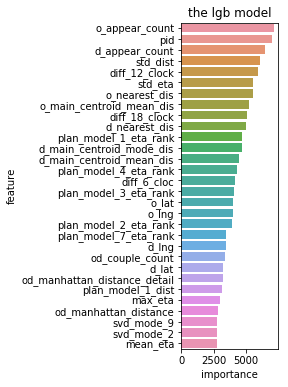

In [185]:
imp = pd.DataFrame()
imp['fea'] = feature
imp['imp'] = lgb_model.feature_importances_ 
imp = imp.sort_values('imp',ascending = False)
imp.to_csv(path + '/feature_import.csv')


#绘制特征重要度图
plt.figure(figsize=(8,6))
plt.subplot(142)
col_imp=pd.DataFrame({'feature':imp['fea'],'importance':imp['imp']}).sort_values(by='importance',ascending=False)
sns.barplot(x=col_imp['importance'][0:30],y=col_imp['feature'][0:30],orient='h')
plt.title('the lgb model')

In [186]:
#data[base_feature].to_csv(path + '/feature_data/pingzhan.csv')

现在先使用低效果的参数进行训练，等使用特征有提升后再使用高精度的参数作为提交时候的使用
       

     

In [187]:
#线上提交
all_train_x              = data[data.req_time < '2018-12-01'][feature].reset_index(drop=True)
all_train_y              = data[data.req_time < '2018-12-01'].click_mode.reset_index(drop=True)
print(lgb_model.best_iteration_)
lgb_model.n_estimators   = lgb_model.best_iteration_
lgb_model.fit(all_train_x, all_train_y)   #best_iteration_  选择最好的一次迭代次数再次进行训练
print('fit over')
result                   = pd.DataFrame()
result['sid']            = data[test_index]['sid']
result['recommend_mode'] = lgb_model.predict(test_x)
result['recommend_mode'] = result['recommend_mode'].astype(int)
print(len(result))
print(result['recommend_mode'].value_counts())
result[['sid', 'recommend_mode']].to_csv(path + '/sub/baseline.csv', index=False)

202
fit over
94358
2     34033
7     22343
1     17886
5     10923
10     3385
0      2228
9      1859
3       623
11      411
6       358
8       249
4        60
Name: recommend_mode, dtype: int64


# 测试

In [190]:
#data.to_csv(path + '/feature_692434.csv')

In [9]:
len(data)

594358

In [10]:
data_train=data[data.req_time < '2018-11-23']

In [11]:
len(data_train)

436612

In [13]:
#在这里尝试写下对  pid下mode出现次数的统计
print('————————      获取每个sid平展      ——————————')

data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
train_index = (data.req_time < '2019-12-01')
train     = data[train_index].reset_index(drop=True)

plans = np.dstack((np.repeat(train['sid'].values,list(map(len,train['plans_json'].values))),np.repeat(train['pid'].values,list(map(len,train['plans_json'].values))),np.repeat(train['click_mode'].values,list(map(len,train['plans_json'].values))),np.concatenate(train['plans_json'].values)))
plans = pd.DataFrame(plans[0],columns=['sid','pid','click_mode','plans'])
plans = pd.concat([plans, pd.DataFrame.from_dict(plans['plans'].tolist())], axis=1)




————————      获取每个sid平展      ——————————


In [20]:
#print(plans)
temp=plans[['pid','transport_mode']].groupby(['pid'])['transport_mode'].value_counts().unstack(fill_value=-1)
temp.columns = ['click_mode_appear_' + str(num) for num in range(11)]
train_x = train_x.merge(temp, on='pid', how='left')

,click_mode_appear_0,click_mode_appear_1,click_mode_appear_2,click_mode_appear_3,click_mode_appear_4,click_mode_appear_5,click_mode_appear_6,click_mode_appear_7,click_mode_appear_8,click_mode_appear_9,click_mode_appear_10
pid,,,,,,,,,,,
100000.0,7,3,8,8,1,1,6,-1,6,2,-1
100002.0,1,1,1,1,-1,1,-1,-1,-1,-1,-1
100005.0,25,19,41,37,12,16,19,-1,9,11,3
100006.0,-1,3,5,3,3,4,1,-1,1,-1,-1
100007.0,2,2,3,3,-1,-1,2,-1,-1,-1,1
100010.0,2,-1,2,2,-1,-1,2,1,-1,1,-1
100011.0,583,398,859,802,264,383,401,25,258,147,48
100012.0,1,-1,1,1,-1,-1,-1,1,-1,-1,-1
100017.0,2,2,2,2,-1,-1,-1,-1,-1,-1,-1


In [22]:
print('————————      获取每个sid平展      ——————————')

data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
train     = data.reset_index(drop=True)

plans = np.dstack((np.repeat(train['sid'].values,list(map(len,train['plans_json'].values))),np.repeat(train['pid'].values,list(map(len,train['plans_json'].values))),np.repeat(train['click_mode'].values,list(map(len,train['plans_json'].values))),np.concatenate(train['plans_json'].values)))
plans = pd.DataFrame(plans[0],columns=['sid','pid','click_mode','plans'])
plans = pd.concat([plans, pd.DataFrame.from_dict(plans['plans'].tolist())], axis=1)


temp=plans[['pid','transport_mode']].groupby(['pid'])['transport_mode'].value_counts().unstack(fill_value=-1)
temp.columns = ['click_mode_appear_' + str(num) for num in range(11)]

train_x = data.merge(temp, on='pid', how='left')


path = 'E:/Machine-learning/kdd_cup_2019/data/'
train_x[['click_mode_appear_' + str(num) for num in range(11)]].to_csv(path + '/feature_data/pid_click_mode_appear_count.csv')

————————      获取每个sid平展      ——————————


In [ ]:
from multiprocessing import Pool
from multiprocessing import cpu_count
processor=cpu_count()-2

data_a=data[data.req_time < '2018-11-23']
data_a=data_a[['sid','pid','click_mode']]
data_b=data[['sid','pid','click_mode']]
def  run_get_pid_mode_count_feature(data_a):
    features=[]
    
    print(len(data_a))
    for i, row in data_a.iterrows():
        #print(i)
        #抽取除当前行的所有行
        the_other_data_row=data_a[data_a['sid']!=row['sid']]
        feature={}
        use_get_CVR_plans_rows=the_other_data_row[the_other_data_row['pid']==row['pid']]
        
        pid_mode_0_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==0)])
        pid_mode_1_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==1)])
        pid_mode_2_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==2)])    
        pid_mode_3_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==3)]) 
        pid_mode_4_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==4)]) 
        pid_mode_5_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==5)]) 
        pid_mode_6_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==6)]) 
        pid_mode_7_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==7)]) 
        pid_mode_8_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==8)]) 
        pid_mode_9_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==9)]) 
        pid_mode_10_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==10)]) 
        pid_mode_11_count=len(use_get_CVR_plans_rows[(use_get_CVR_plans_rows['click_mode']==11)]) 
        
        feature['pid_mode_0_count']=pid_mode_0_count
        feature['pid_mode_1_count']=pid_mode_1_count
        feature['pid_mode_2_count']=pid_mode_2_count
        feature['pid_mode_3_count']=pid_mode_3_count
        feature['pid_mode_4_count']=pid_mode_4_count
        feature['pid_mode_5_count']=pid_mode_5_count
        feature['pid_mode_6_count']=pid_mode_6_count
        feature['pid_mode_7_count']=pid_mode_7_count
        feature['pid_mode_8_count']=pid_mode_8_count
        feature['pid_mode_9_count']=pid_mode_9_count
        feature['pid_mode_10_count']=pid_mode_10_count
        feature['pid_mode_11_count']=pid_mode_11_count
        
        features.append(feature)
    features=pd.DataFrame(features)
    return features


def get_pid_mode_count_feature(data_a):
    #并行化执行对训练集的统计函数    这里用6个核心进行并行化处理，来加速计算   
    res = []
    p = Pool(processor)
    df_parts=np.array_split(data_a,6)  
    
    for i in range(processor):
        res.append(p.apply_async(run_get_pid_mode_count_feature, args=(df_parts[i])))
        print(str(i) + ' processor started !')
    p.close()
    p.join()

    data=pd.concat([i.get() for i in res])
    
    data.to_csv(path + '/feature_data/pid_mode_count_feature.csv',index=False)
    

pid_mode_count_feature=get_pid_mode_count_feature(data_a)

0 processor started !
1 processor started !
2 processor started !
3 processor started !
4 processor started !
5 processor started !


In [ ]:
import time
print time.time()